In [1]:
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from datetime import datetime

from collections import defaultdict
from tqdm.notebook import tqdm

### Bootstrap and Confidence Intervals

Суть метода бутстреп состоит в том, что **по имеющейся выборке мы можем построить эмпирическое распределение**. 
Это эмпирическое распределение будет **апроксимировать исходное неизвестное нам распределение ГС**.

Для того, чтобы узнать значение произвольной статистики, мы можем сгенерировать случайную выборку из распределения. 
Поскольку настоящее распределение нам неизвестно, то мы заменяем его апроксимацией — 
указанным ранее эмпирическим распределением. 

```
random.choice(a, size=None, replace=True, p=None)
```

При этом мы можем указать размер выборки — произвольный кортеж натуральных чисел. 
Такой способ гораздо эффективнее, чем последовательно генерировать несколько выборок.

Каждая из порожденных выборок дает точечную оценку для интересующей нас статистики. 
В целом же многократно сгенерированные выборки дают нам возможность построить распределение интересующей статистики.

### Finding the Statistic's Distribution Using Bootstrap

Сгенерируем выборку из [Гамма распределения]
На её основе можно сформировать множество бутстрепных подвыборок. 
Наша задача - посчитать точечную оценку для коэффициентов данного распределения, 
а так же на основе бутстрепных оценок построить распределение для этих оценок и указать доверительный интервал. 
Сравнить всё это с известными значениями коэффициента ассиметрии для гамма распределения.


In [36]:
N = 100
param_a = 3
param_scale = 5
distribution = stats.gamma(a=param_a, scale=param_scale)
x = distribution.rvs(size=N, random_state=23)

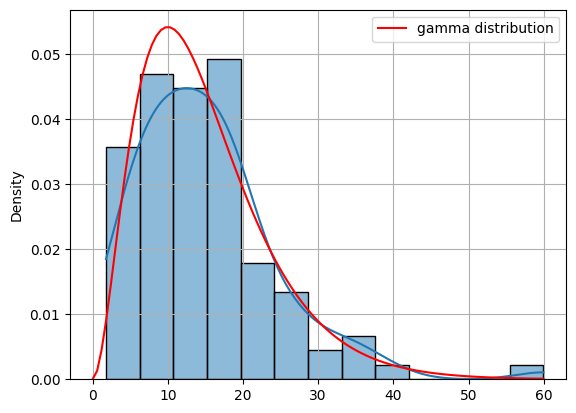

In [37]:
xa = np.linspace(0, max(x), 100)
pdf = distribution.pdf(xa)

sns.histplot(data=x, kde=True, stat='density')
plt.plot(xa, pdf, label='gamma distribution', c='r')
plt.legend()
plt.grid()

Так же можно легко построить эмпирическую функцию распределения и сравнить её с настоящей:

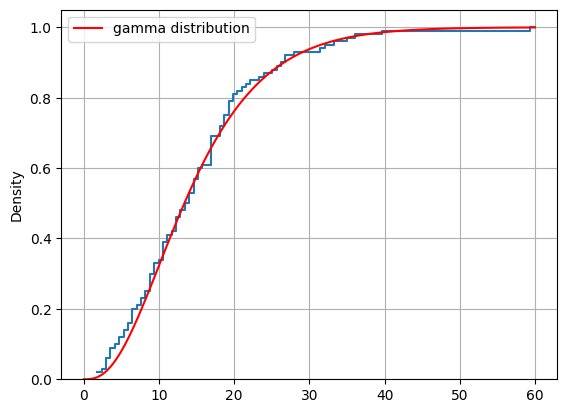

In [13]:
cdf = distribution.cdf(xa)

sns.histplot(
    data=x, cumulative=True, stat='density', 
    fill=False, element='step', bins=100
)

plt.plot(xa, cdf, label='gamma distribution', c='r')
plt.legend()
plt.grid()

### Point Estimate of the Statistic

Мы можем для нашей выборки получить точечную оценку для $\hat{k}$ и $\hat{\theta}$ (для $a$ и $scale$ соответственно). 
Напомним, что вычисляются они как

$$
\hat{k} = \frac{N \sum_{i=1}^N X_i}{N \sum_{i=1}^N X_i \ln(X_i) - \sum_{i=1}^N X_i \sum_{i=1}^N \ln(X_i)}
$$

$$
\hat{\theta} = \frac{1}{N^2} \left(N \sum_{i=1}^N X_i \ln(X_i) - \sum_{i=1}^N X_i \sum_{i=1}^N \ln(X_i)\right)
$$

Использование выборочного среднего значения $x$, выборочного среднего значения $\ln{X}$ 
и выборочного среднего значения произведения $x\ln{X}$ упрощает выражения до:

$$
\hat{k} = \bar{X} / \hat{\theta}
$$

$$
\hat{\theta} = \overline{X\ln{X}} - \bar{X} \overline{\ln{X}}
$$

Хотя эти оценки непротиворечивы, они имеют небольшое смещение. Варианты оценок с поправкой на смещение представлены ниже

$$
\tilde{\theta} = \frac{N}{N - 1} \hat{\theta}
$$
$$
\tilde{k} = \hat{k} - \frac{1}{N} \left(3 \hat{k} - \frac{2}{3} \left(\frac{\hat{k}}{1 + \hat{k}}\right) - \frac{4}{5} \frac{\hat{k}}{(1 + \hat{k})^2} \right)
$$

Мы можем посчитать точечную оценку для нашей выборки и сравнить с известным значением для распределения.



In [14]:
def estimate_scale(x):
    logx = np.log(x)
    scale = np.mean(x * logx) - np.mean(x) * np.mean(logx)
    return len(x) / (len(x) - 1) * scale

def estimate_a(x):
    scale = estimate_scale(x)
    a = np.mean(x) / scale
    return a
    return a - 1 / len(x) * (3 * a - 2/3 * (a / (1 + a) - 4/5 * (a / (1 + a) ** 2)))

In [15]:
print(f'real a = {param_a}, estimated_a = {estimate_a(x)}')
print(f'real scale = {param_scale}, estimated_scale = {estimate_scale(x)}')

real a = 3, estimated_a = 2.634912717258704
real scale = 5, estimated_scale = 5.712751769844184


### Bootstrap and Confidence Intervals Construction

С помощью бутстрепа мы можем из имеющейся выборки сгенерировать множество подвыборок. 
Для каждой из этих подвыборок можно построить точечную оценку и тем самым получить распределение 
бутстрепных точечных оценок для интересующей нас статистики.

Для таких распределений мы можем построить доверительные интервалы. Например, доверительный интервал на основе процентилей.


In [38]:
alpha = 0.05

B = 1000
real_stat = 5
bs_estimates = []

for _ in range(B):
    bs = np.random.choice(x, size=len(x), replace=True)
    bs_estimate = estimate_a(bs)
    bs_estimates.append(bs_estimate)

bound = np.quantile(bs_estimates, [alpha/2, 1 - alpha/2])
print(bound)

[2.05284022 3.62851438]


Важно заметить, что **при всей мощи бутстрепа он не может преодолеть недостатки конкретной выборки**. 
Если сгенерированная нами выборка не отражает определенных свойств исходного распределения, 
то бутстрепу дополнительную информацию брать просто неоткуда. 
В частности даже доверительные интервалы могут не покрыть истинного значения.


In [39]:
N = 1000
alpha = 0.05
B = 1000
# real_stat, estimator = param_a, estimate_a
real_stat, estimator = param_scale, estimate_scale

for _ in range(100): # generating 100 samples from the same Gamma distribution
    distribution = stats.gamma(a=3, scale=5)   # "Истинное" распределение
    x = distribution.rvs(size=N)  # Выборка из этого распределения
    point_estimate = estimator(x) # Точечная оценка параметра из выборки (например, scale)
    bs_estimates = []

    for _ in range(B): # Бутстрапим 1000 подвыборок из одной выборки
        bs = np.random.choice(x, size=len(x), replace=True) 
        bs_estimate = estimator(bs)  # Оцениваем параметр (например, scale)
        bs_estimates.append(bs_estimate)

    bounds = np.quantile(bs_estimates, [alpha / 2, 1 - alpha / 2]) # Бутстрапный ДИ
    if bounds[0] <= real_stat <= bounds[1]: # Проверяем, входит ли "истинное" значение параметра
        continue

    print(bounds)

[4.11381078 4.88736184]
[4.12940314 4.96797291]
[5.11985858 6.22804708]
[4.0792616  4.84360321]
[3.95225658 4.70044443]
[4.15576829 4.96457665]
[4.13247918 4.90682694]


Видим, что **при заданном уровне значимости 0.05 в 3 случаях из 100 построенный ДИ не включает в себя 
истинное значение статистики**.

### Three Methods of Confidence Interval Construction

Если вы хотите узнать больше о способах построения доверительных интервалов, 
предлагаем прочитать статью [Бутстреп и А/Б тестирование](https://habr.com/ru/company/X5Tech/blog/679842/).

In [47]:
def get_ci_bootstrap_normal(boot_metrics: np.array, pe_metric: float, alpha: float=0.05):
    """Строит нормальный доверительный интервал.

    boot_metrics - значения метрики, полученные с помощью бутстрепа
    pe_metric - точечная оценка метрики
    alpha - уровень значимости
    
    return: (left, right) - границы доверительного интервала.
    """
    c = stats.norm.ppf(1 - alpha/2)
    se = np.std(boot_metrics)
    left, right = pe_metric - c * se, pe_metric + c * se
    return left, right


def get_ci_bootstrap_percentile(boot_metrics: np.array, pe_metric: float, alpha: float=0.05):
    """Строит доверительный интервал на процентилях.

    boot_metrics - значения метрики, полученные с помощью бутстрепа
    pe_metric - точечная оценка метрики
    alpha - уровень значимости
    
    return: (left, right) - границы доверительного интервала.
    """
    left, right = np.quantile(boot_metrics, [alpha/2, 1-alpha/2]) # quantile в долях
    return left, right

def get_ci_bootstrap_pivotal(boot_metrics: np.array, pe_metric: float, alpha: float=0.05):
    """Строит центральный доверительный интервал.

    boot_metrics - значения метрики, полученные с помощью бутстрепа
    pe_metric - точечная оценка метрики
    alpha - уровень значимости
    
    return: (left, right) - границы доверительного интервала.
    """
    right, left = 2 * pe_metric - np.quantile(boot_metrics, [alpha/2, 1-alpha/2])
    return left, right


### Validation Check

In [45]:
def check_ttest(a, b, alpha=0.05):
    """Тест Стьюдента. Возвращает 1, если отличия значимы."""
    _, pvalue = stats.ttest_ind(a, b)
    return int(pvalue < alpha)


def check_bootstrap(a, b, func=np.mean, B=1000, alpha=0.05):
    """Бутстреп. Возвращает 1, если отличия значимы."""
    a_bootstrap = np.random.choice(a, size=(B, len(a)), replace=True)
    b_bootstrap = np.random.choice(b, size=(B, len(b)), replace=True)
    list_diff = func(a_bootstrap, axis=1) - func(b_bootstrap, axis=1) # mean_a - mean_b for 1000 
    left_bound, right_bound = get_ci_bootstrap_percentile(list_diff, None)
    res = 1 if (left_bound > 0) or (right_bound < 0) else 0
    return res

dict_tests = {
    'ttest': check_ttest,
    'bootstrap': check_bootstrap
}

#### Checking if Both Bootstrap and T-test Work Correctly

Запустим их на выборках из одинаковых распределений, убедимся, что они редко ошибочно находят эффект.

In [49]:
significant_results = defaultdict(list)

for _ in tqdm(range(1000)):
    a = np.random.normal(0, 1, 100)
    b = np.random.normal(0.4, 1, 100)
    for test_name, test in dict_tests.items():
        significant_results[test_name].append(test(a, b))
print({test_name: np.mean(rejected) for test_name, rejected in significant_results.items()}) 


  0%|          | 0/1000 [00:00<?, ?it/s]

{'ttest': 0.803, 'bootstrap': 0.811}


In [50]:
## === AA test for example ===
from collections import defaultdict
from tqdm import tqdm
import numpy as np

significant_results = defaultdict(list)

for _ in tqdm(range(1000)):  # 1000 A/A-тестов
    a = np.random.normal(0, 1, 100)
    b = np.random.normal(0, 1, 100)  # Та же генерация, что и у a!
    for test_name, test in dict_tests.items():
        significant_results[test_name].append(test(a, b))

# Считаем долю ложных срабатываний (ошибок 1-го рода)
print({test_name: np.mean(rejected) for test_name, rejected in significant_results.items()})


100%|██████████| 1000/1000 [00:04<00:00, 247.16it/s]

{'ttest': 0.053, 'bootstrap': 0.056}


#### Comparing the Speed of Both Tests

Видим, что вычисления занимают некоторое время. Сравним скорость вычисления тестов в зависимости от размера выборки.

In [56]:
test_times = {test_name: [] for test_name in dict_tests}
sample_sizes = np.logspace(2, 5, 20).astype(int)

for sample_size in tqdm(sample_sizes):
    a = np.random.normal(0, 1, sample_size)
    b = np.random.normal(0, 1, sample_size)
    for test_name, test in dict_tests.items():
        t1 = time.time()
        test(a, b)
        t2 = time.time()
        test_times[test_name].append(t2 - t1)

100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


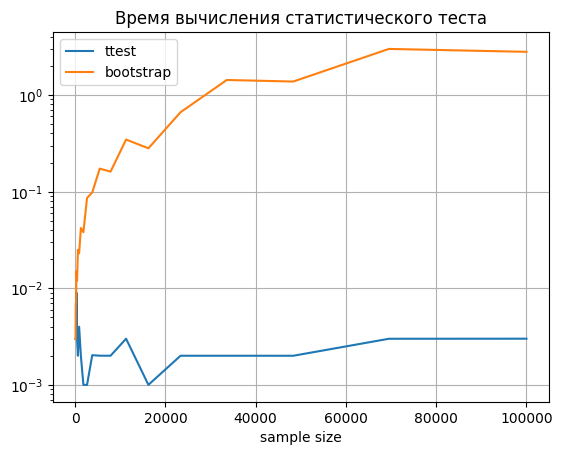

In [57]:
for test_name, times in test_times.items():
    plt.plot(sample_sizes, times, label=test_name)
plt.title('Время вычисления статистического теста')
plt.grid()
plt.xlabel('sample size')
plt.yscale('log')
plt.legend()
plt.show()

Видно, что ttest отрабатывает значительно быстрее. 
Время работы теста бутстрепа заметно растет при увеличении объёма данных.

Заметим, что **бутстреп на несколько порядков медленнее. 
Он полезен для построения доверительных интервалов оценок, 
но для проверки гипотез о равенстве средних на больших данных его лучше не использовать из-за скорости работы**.


### Dependence on Sample Size

In [60]:
np.random.seed(23)

N = 5000
alpha = 0.05
B = 1000
# real_stat, estimator = param_a, estimate_a
real_stat, estimator = param_scale, estimate_scale


distribution = stats.gamma(a=3, scale=5)
all_data = distribution.rvs(size=N)

point_estimates = []
bounds_list = []
sizes = np.linspace(50, N+1, 50).astype(np.int32)

for size in tqdm(sizes):
    x = all_data[:size]
    point_estimate = estimator(x)
    point_estimates.append(point_estimate)

    bs_estimates = []
    for _ in range(B):
        bs = np.random.choice(x, size=len(x), replace=True)
        bs_estimate = estimator(bs)
        bs_estimates.append(bs_estimate)

    bounds = np.quantile(bs_estimates, [alpha / 2, 1 - alpha / 2])
    bounds_list.append(bounds)

bounds_list = np.array(bounds_list)

100%|██████████| 50/50 [00:04<00:00, 11.00it/s]


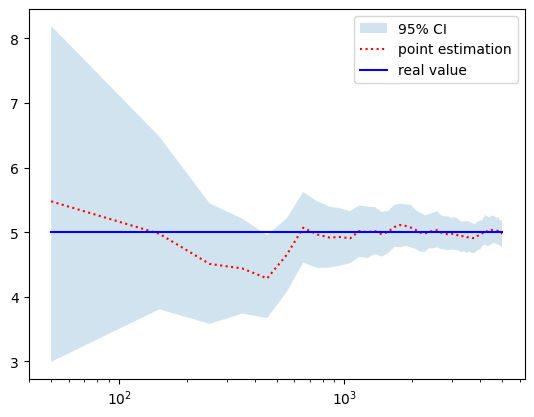

In [61]:
plt.xscale('log')
plt.fill_between(sizes, bounds_list[:, 0], bounds_list[:, 1], alpha=0.2, label=f'{int(100 - alpha*100)}% CI')
plt.plot(sizes, point_estimates, ':r', label=f'point estimation')
plt.plot(sizes, [real_stat] * len(sizes), 'b', label=f'real value')
plt.legend()

Обратите внимание, что ось $Ox$ **логарифмическая**. 
С ростом размера **выборки** (не с ростом размера бутстрепных итераций) обычно доверительный интервал сужается.

### Pizzeria's Data


In [62]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

In [63]:
web_logs = read_database('2022-04-01T12_df_web_logs.csv')
web_logs['date'] = pd.to_datetime(web_logs['date'])
web_logs.head(3)

,user_id,page,date,load_time
0,f25239,m,2022-02-03 23:45:37,80.8
1,06d6df,m,2022-02-03 23:49:56,70.5
2,06d6df,m,2022-02-03 23:51:16,89.7


web-logs — таблица с логами посещения сайта.

1. user_id — идентификатор пользователя;
2. page — какая страница сайта была открыта. Типы страниц:
    + m — страница с меню;
    + b  — страница с корзиной и подтверждением заказа;
    + p — страница с оплатой заказа;
3. date — дата открытия страницы;
4. load_time — время загрузки страницы в миллисекундах.

**Предполагается, что данные независимы**

In [70]:
np.random.seed(23)

web_logs_hist = web_logs
users = web_logs_hist['user_id'].unique()

np.random.shuffle(users)
group_a, group_b = users[:len(users) // 2], users[len(users) // 2:]
load_time_a = web_logs_hist[web_logs_hist['user_id'].isin(group_a)]['load_time'].values
load_time_b = web_logs_hist[web_logs_hist['user_id'].isin(group_b)]['load_time'].values


Нашей целью будет построить $95\%$ доверительный интервал для разницы $99.9%$ перцентилей.

$$H_0: P_{B; 99.9} = P_{A; 99.9}$$
$$H_1: P_{B; 99.9} \neq P_{A; 99.9}$$

Сначала реализуем функцию, с помощью которой мы можем получить точечную оценку

In [71]:
def get_point_estimate(a_group, b_group, quantile=0.999):
    return np.quantile(b_group, quantile) - np.quantile(a_group, quantile)

Запустим обычную процедуру бутстрепа, но с учетом того, что у нас две выборки. 
Для этого будем независимо семплировать из групп подвыборки такого же размера и считать бутстрепную оценку. 
Повторим данную процедуру 1000 раз.


In [79]:
point_estimate = get_point_estimate(load_time_a, load_time_b)
print(point_estimate)

bs_point_estimates = []
generator = np.random.default_rng()

for _ in tqdm(range(1000)):
    bs_a = generator.choice(load_time_a, size=len(load_time_a), replace=True)
    bs_b = generator.choice(load_time_b, size=len(load_time_b), replace=True)
    bs_point_estimate = get_point_estimate(bs_a, bs_b)
    bs_point_estimates.append(bs_point_estimate)


-108.90149999987307


100%|██████████| 1000/1000 [00:53<00:00, 18.82it/s]


Построим доверительные интервалы тремя разнымы способами и отобразим их на гистограмме.

In [81]:
normal_ci = get_ci_bootstrap_normal(bs_point_estimates, point_estimate)
percentile_ci = get_ci_bootstrap_percentile(bs_point_estimates, point_estimate)
pivotal_ci = get_ci_bootstrap_pivotal(bs_point_estimates, point_estimate)

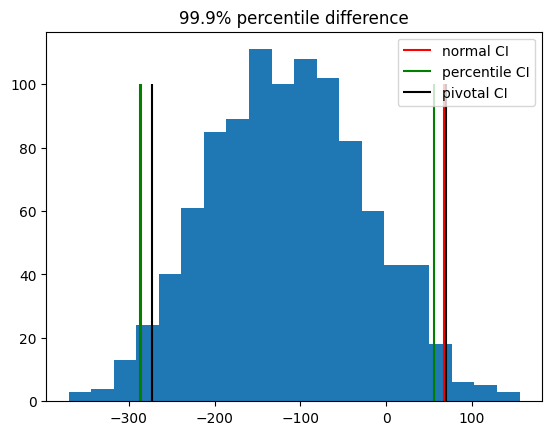

In [82]:
plt.title('99.9% percentile difference')
plt.hist(bs_point_estimates, bins=20)
plt.vlines(normal_ci, 0, 100, label='normal CI', color='red')
plt.vlines(percentile_ci, 0, 100, label='percentile CI', color='green')
plt.vlines(pivotal_ci, 0, 100, label='pivotal CI', color='black')
plt.legend()
plt.show()

**Вывод**: ноль входит внутрь доверительного интервала, а значит мы не можем отвергнуть нулевую гипотезу о том, 
что 99.9 перцентиль отличается статистически значимо.

### Эксперимент «Refactoring backend»

In [ ]:
# В эксперименте «Refactoring backend» в экспериментальной группе 
# среднее время загрузки увеличилось, а 99% квантиль уменьшился. Проверим значимость отличий других квантилей.

# Данные эксперимента «Refactoring backend»: 2022-04-13/2022-04-13T12_df_web_logs.csv и 2022-04-13/experiment_users.csv. 

# Эксперимент проводился с 2022-04-05 по 2022-04-12.
# Измерения времени обработки запросов считаем независимыми. 
# При проверке используйте нормальный доверительный интервал.
# Квантили для проверки: 0.70, 0.74, 0.78, 0.82, 0.86, 0.90, 0.95, 0.99, 0.999, 0.9999.

# Importing data
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

df_logs = read_database('2022-04-13/2022-04-13T12_df_web_logs.csv')
df_logs['date'] = pd.to_datetime(df_logs['date'])

df_users = read_database('2022-04-13/experiment_users.csv')

begin_date = datetime(2022, 4, 5)
end_date = datetime(2022, 4, 12)
print(f"df_logs:\n {df_logs.head()}")
print(f"df_users:\n {df_users.head()}")

df_logs:
   user_id page                date  load_time
0  f25239    m 2022-02-03 23:45:37       80.8
1  06d6df    m 2022-02-03 23:49:56       70.5
2  06d6df    m 2022-02-03 23:51:16       89.7
3  f25239    m 2022-02-03 23:51:43       74.4
4  697870    m 2022-02-03 23:53:12       66.8
df_users:
   user_id  pilot
0  c36b2e      0
1  20336e      0
2  034652      0
3  e98e3b      0
4  3f1105      0


In [111]:
def get_point_estimate(a_group: np.array, b_group: np.array, quantile: float):
    return np.quantile(b_group, quantile) - np.quantile(a_group, quantile)

def get_ci_bootstrap_normal(boot_metrics: np.array, pe_metric: float, alpha: float=0.05):
    """Строит нормальный доверительный интервал.

    boot_metrics - значения метрики, полученные с помощью бутстрепа
    pe_metric - точечная оценка метрики
    alpha - уровень значимости
    
    return: (left, right) - границы доверительного интервала.
    """
    c = stats.norm.ppf(1 - alpha/2)
    se = np.std(boot_metrics)
    left, right = pe_metric - c * se, pe_metric + c * se
    return left, right

df_load_times = (
    df_logs
    [(df_logs['date']>=begin_date) & (df_logs['date'] < end_date)]
    [['user_id', 'load_time']]
    .reset_index(drop=True)
)

# можно соединение df_load_times с df_users сделать по user_id и сохранить только pilot | load_time (поскольку считаем что данные "независимые" и среднее по user находить не нужно)
df_merged = df_users.merge(df_load_times, on='user_id', how='left').fillna(0)[['pilot', 'load_time']]

B = 1000
alpha = 0.05
values_a = df_merged[df_merged['pilot'] == 0]['load_time'].values
values_b = df_merged[df_merged['pilot'] == 1]['load_time'].values

quantiles = np.array([0.7, 0.74, 0.78, 0.82, 0.86, 0.9, 0.95, 0.99, 0.999, 0.9999])

for q in quantiles:
    pe = np.quantile(values_b, q) - np.quantile(values_a, q)
    bs_a = np.random.choice(values_a, (B, len(values_a)), replace=True)
    bs_b = np.random.choice(values_b, size=(B, len(values_b)), replace=True)
    bs_metrics_a = np.quantile(bs_a, q, axis=1)
    bs_metrics_b = np.quantile(bs_b, q, axis=1)
    bs_stats = bs_metrics_b - bs_metrics_a
    left, right = get_ci_bootstrap_normal(bs_stats, pe, alpha)
    print(f'q = {q}, ci = [{left:0.3f}, {right:0.3f}], is effect = {not(left < 0 < right)} ')
    


q = 0.7, ci = [0.727, 1.273], is effect = True 
q = 0.74, ci = [0.296, 0.904], is effect = True 
q = 0.78, ci = [-0.311, 0.311], is effect = False 
q = 0.82, ci = [-1.012, -0.388], is effect = True 
q = 0.86, ci = [-1.548, -0.852], is effect = True 
q = 0.9, ci = [-2.506, -1.694], is effect = True 
q = 0.95, ci = [-3.892, -3.018], is effect = True 
q = 0.99, ci = [-7.299, -5.301], is effect = True 
q = 0.999, ci = [-1882.914, 1104.644], is effect = False 
q = 0.9999, ci = [-414.326, 477.751], is effect = False 


### Метод _run_bootstrap для класса ExperimentsService

In [113]:

import numpy as np
import pandas as pd
from pydantic import BaseModel
from scipy import stats


class Design(BaseModel):
    """Дата-класс с описание параметров эксперимента.
    
    statistical_test - тип статтеста. ['ttest', 'bootstrap']
    effect - размер эффекта в процентах
    alpha - уровень значимости
    beta - допустимая вероятность ошибки II рода
    bootstrap_iter - количество итераций бутстрепа
    bootstrap_ci_type - способ построения доверительного интервала. ['normal', 'percentile', 'pivotal']
    bootstrap_agg_func - метрика эксперимента. ['mean', 'quantile 95']
    """
    statistical_test: str
    effect: float
    alpha: float = 0.05
    beta: float = 0.1
    bootstrap_iter: int = 1000
    bootstrap_ci_type: str
    bootstrap_agg_func: str


class ExperimentsService:

    def _generate_bootstrap_metrics(self, data_one, data_two, design):
        """Генерирует значения метрики, полученные с помощью бутстрепа.
        
        :param data_one, data_two (np.array): значения метрик в группах.
        :param design (Design): объект с данными, описывающий параметры эксперимента
        :return bootstrap_metrics, pe_metric:
            bootstrap_metrics (np.array) - значения статистики теста псчитанное по бутстрепным подвыборкам
            pe_metric (float) - значение статистики теста посчитанное по исходным данным
        """
        bootstrap_data_one = np.random.choice(data_one, (len(data_one), design.bootstrap_iter))
        bootstrap_data_two = np.random.choice(data_two, (len(data_two), design.bootstrap_iter))
        if design.bootstrap_agg_func == 'mean':
            bootstrap_metrics = bootstrap_data_two.mean(axis=0) - bootstrap_data_one.mean(axis=0)
            pe_metric = data_two.mean() - data_one.mean()
            return bootstrap_metrics, pe_metric
        elif design.bootstrap_agg_func == 'quantile 95':
            bootstrap_metrics = (
                np.quantile(bootstrap_data_two, 0.95, axis=0)
                - np.quantile(bootstrap_data_one, 0.95, axis=0)
            )
            pe_metric = np.quantile(data_two, 0.95) - np.quantile(data_one, 0.95)
            return bootstrap_metrics, pe_metric
        else:
            raise ValueError('Неверное значение design.bootstrap_agg_func')

    def _run_bootstrap(self, bootstrap_metrics, pe_metric, design):
        """Строит доверительный интервал и проверяет значимость отличий с помощью бутстрепа.
        
        :param bootstrap_metrics (np.array): статистика теста, посчитанная на бутстрепных выборках.
        :param pe_metric (float): значение статистики теста посчитанное по исходным данным.
        :return ci, pvalue:
            ci [float, float] - границы доверительного интервала
            pvalue (float) - 0 если есть статистически значимые отличия, иначе 1.
                Настоящее pvalue для произвольного способа построения доверительного интервала с помощью
                бутстрепа вычислить не тривиально. Поэтому мы будем использовать краевые значения 0 и 1.
        """
        # bootstrap_ci_type - способ построения доверительного интервала. ['normal', 'percentile', 'pivotal']
        # YOUR_CODE_HERE
        if design.bootstrap_ci_type == 'normal':
            c = stats.norm.ppf(1 - design.alpha/2)
            se = np.std(bootstrap_metrics)
            left, right = pe_metric - c * se, pe_metric + c * se
        elif design.bootstrap_ci_type == 'percentile':
            left, right = np.quantile(bootstrap_metrics, [design.alpha/2, 1-design.alpha/2]) # quantile в долях
        elif design.bootstrap_ci_type == 'pivotal':
            right, left = 2 * pe_metric - np.quantile(bootstrap_metrics, [design.alpha/2, 1-design.alpha/2])
        else:
            raise ValueError('Неверно значение design.bootstrap_ci_type')
        pvalue = float(left < 0 < right)
        return (left, right,), pvalue


    def get_pvalue(self, metrics_a_group, metrics_b_group, design):
        """Применяет статтест, возвращает pvalue.
        
        :param metrics_a_group (np.array): массив значений метрик группы A
        :param metrics_a_group (np.array): массив значений метрик группы B
        :param design (Design): объект с данными, описывающий параметры эксперимента
        :return (float): значение p-value
        """
        if design.statistical_test == 'ttest':
            _, pvalue = stats.ttest_ind(metrics_a_group, metrics_b_group)
            return pvalue
        elif design.statistical_test == 'bootstrap':
            bootstrap_metrics, pe_metric = self._generate_bootstrap_metrics(metrics_a_group, metrics_b_group, design)
            _, pvalue = self._run_bootstrap(bootstrap_metrics, pe_metric, design)
        else:
            raise ValueError('Неверный design.statistical_test')

if __name__ == '__main__':
    bootstrap_metrics = np.arange(-490, 510)
    pe_metric = 5.
    design = Design(
        statistical_test='bootstrap',
        effect=5,
        bootstrap_ci_type='normal',
        bootstrap_agg_func='mean'
    )
    ideal_ci = (-560.79258, 570.79258)
    ideal_pvalue = 1.

    experiments_service = ExperimentsService()
    ci, pvalue = experiments_service._run_bootstrap(bootstrap_metrics, pe_metric, design)
    np.testing.assert_almost_equal(ideal_ci, ci, decimal=4, err_msg='Неверный доверительный интервал')
    assert ideal_pvalue == pvalue, 'Неверный pvalue'
    print('simple test passed')

simple test passed


In [ ]:
def get_ci_bootstrap_normal(boot_metrics: np.array, pe_metric: float, alpha: float=0.05):
    """Строит нормальный доверительный интервал.

    boot_metrics - значения метрики, полученные с помощью бутстрепа
    pe_metric - точечная оценка метрики
    alpha - уровень значимости
    
    return: (left, right) - границы доверительного интервала.
    """
    c = stats.norm.ppf(1 - alpha/2)
    se = np.std(boot_metrics)
    left, right = pe_metric - c * se, pe_metric + c * se
    return left, right


def get_ci_bootstrap_percentile(boot_metrics: np.array, pe_metric: float, alpha: float=0.05):
    """Строит доверительный интервал на процентилях.

    boot_metrics - значения метрики, полученные с помощью бутстрепа
    pe_metric - точечная оценка метрики
    alpha - уровень значимости
    
    return: (left, right) - границы доверительного интервала.
    """
    left, right = np.quantile(boot_metrics, [alpha/2, 1-alpha/2]) # quantile в долях
    return left, right

def get_ci_bootstrap_pivotal(boot_metrics: np.array, pe_metric: float, alpha: float=0.05):
    """Строит центральный доверительный интервал.

    boot_metrics - значения метрики, полученные с помощью бутстрепа
    pe_metric - точечная оценка метрики
    alpha - уровень значимости
    
    return: (left, right) - границы доверительного интервала.
    """
    right, left = 2 * pe_metric - np.quantile(boot_metrics, [alpha/2, 1-alpha/2])
    return left, right


In [114]:

import numpy as np
import pandas as pd
from pydantic import BaseModel
from scipy import stats


class Design(BaseModel):
    """Дата-класс с описание параметров эксперимента.
    
    statistical_test - тип статтеста. ['ttest', 'bootstrap']
    effect - размер эффекта в процентах
    alpha - уровень значимости
    beta - допустимая вероятность ошибки II рода
    bootstrap_iter - количество итераций бутстрепа
    bootstrap_ci_type - способ построения доверительного интервала. ['normal', 'percentile', 'pivotal']
    bootstrap_agg_func - метрика эксперимента. ['mean', 'quantile 95']
    """
    statistical_test: str
    effect: float
    alpha: float = 0.05
    beta: float = 0.1
    bootstrap_iter: int = 1000
    bootstrap_ci_type: str
    bootstrap_agg_func: str


class ExperimentsService:
    def get_ci_bootstrap_normal(boot_metrics: np.array, pe_metric: float, alpha: float=0.05):
        """Строит нормальный доверительный интервал.

        boot_metrics - значения метрики, полученные с помощью бутстрепа
        pe_metric - точечная оценка метрики
        alpha - уровень значимости
        
        return: (left, right) - границы доверительного интервала.
        """
        c = stats.norm.ppf(1 - alpha/2)
        se = np.std(boot_metrics)
        left, right = pe_metric - c * se, pe_metric + c * se
        return left, right


    def get_ci_bootstrap_percentile(boot_metrics: np.array, pe_metric: float, alpha: float=0.05):
        """Строит доверительный интервал на процентилях.

        boot_metrics - значения метрики, полученные с помощью бутстрепа
        pe_metric - точечная оценка метрики
        alpha - уровень значимости
        
        return: (left, right) - границы доверительного интервала.
        """
        left, right = np.quantile(boot_metrics, [alpha/2, 1-alpha/2]) # quantile в долях
        return left, right

    def get_ci_bootstrap_pivotal(boot_metrics: np.array, pe_metric: float, alpha: float=0.05):
        """Строит центральный доверительный интервал.

        boot_metrics - значения метрики, полученные с помощью бутстрепа
        pe_metric - точечная оценка метрики
        alpha - уровень значимости
        
        return: (left, right) - границы доверительного интервала.
        """
        right, left = 2 * pe_metric - np.quantile(boot_metrics, [alpha/2, 1-alpha/2])
        return left, right

    def _generate_bootstrap_metrics(self, data_one, data_two, design):
        """Генерирует значения метрики, полученные с помощью бутстрепа.
        
        :param data_one, data_two (np.array): значения метрик в группах.
        :param design (Design): объект с данными, описывающий параметры эксперимента
        :return bootstrap_metrics, pe_metric:
            bootstrap_metrics (np.array) - значения статистики теста псчитанное по бутстрепным подвыборкам
            pe_metric (float) - значение статистики теста посчитанное по исходным данным
        """
        bootstrap_data_one = np.random.choice(data_one, (len(data_one), design.bootstrap_iter))
        bootstrap_data_two = np.random.choice(data_two, (len(data_two), design.bootstrap_iter))
        if design.bootstrap_agg_func == 'mean':
            bootstrap_metrics = bootstrap_data_two.mean(axis=0) - bootstrap_data_one.mean(axis=0)
            pe_metric = data_two.mean() - data_one.mean()
            return bootstrap_metrics, pe_metric
        elif design.bootstrap_agg_func == 'quantile 95':
            bootstrap_metrics = (
                np.quantile(bootstrap_data_two, 0.95, axis=0)
                - np.quantile(bootstrap_data_one, 0.95, axis=0)
            )
            pe_metric = np.quantile(data_two, 0.95) - np.quantile(data_one, 0.95)
            return bootstrap_metrics, pe_metric
        else:
            raise ValueError('Неверное значение design.bootstrap_agg_func')

    def _run_bootstrap(self, bootstrap_metrics, pe_metric, design):
        """Строит доверительный интервал и проверяет значимость отличий с помощью бутстрепа.
        
        :param bootstrap_metrics (np.array): статистика теста, посчитанная на бутстрепных выборках.
        :param pe_metric (float): значение статистики теста посчитанное по исходным данным.
        :return ci, pvalue:
            ci [float, float] - границы доверительного интервала
            pvalue (float) - 0 если есть статистически значимые отличия, иначе 1.
                Настоящее pvalue для произвольного способа построения доверительного интервала с помощью
                бутстрепа вычислить не тривиально. Поэтому мы будем использовать краевые значения 0 и 1.
        """
        # bootstrap_ci_type - способ построения доверительного интервала. ['normal', 'percentile', 'pivotal']
        if design.bootstrap_ci_type == 'normal':
            left, right = get_ci_bootstrap_normal(bootstrap_metrics, pe_metric, design.alpha)
        elif design.bootstrap_ci_type == 'percentile':
            left, right = get_ci_bootstrap_percentile(bootstrap_metrics, pe_metric, design.alpha)
        elif design.bootstrap_ci_type == 'pivotal':
            right, left = get_ci_bootstrap_pivotal(bootstrap_metrics, pe_metric, design.alpha)
        else:
            raise ValueError('Неверно значение design.bootstrap_ci_type')
        pvalue = float(left < 0 < right)
        return (left, right,), pvalue


    def get_pvalue(self, metrics_a_group, metrics_b_group, design):
        """Применяет статтест, возвращает pvalue.
        
        :param metrics_a_group (np.array): массив значений метрик группы A
        :param metrics_a_group (np.array): массив значений метрик группы B
        :param design (Design): объект с данными, описывающий параметры эксперимента
        :return (float): значение p-value
        """
        if design.statistical_test == 'ttest':
            _, pvalue = stats.ttest_ind(metrics_a_group, metrics_b_group)
            return pvalue
        elif design.statistical_test == 'bootstrap':
            bootstrap_metrics, pe_metric = self._generate_bootstrap_metrics(metrics_a_group, metrics_b_group, design)
            _, pvalue = self._run_bootstrap(bootstrap_metrics, pe_metric, design)
        else:
            raise ValueError('Неверный design.statistical_test')

if __name__ == '__main__':
    bootstrap_metrics = np.arange(-490, 510)
    pe_metric = 5.
    design = Design(
        statistical_test='bootstrap',
        effect=5,
        bootstrap_ci_type='normal',
        bootstrap_agg_func='mean'
    )
    ideal_ci = (-560.79258, 570.79258)
    ideal_pvalue = 1.

    experiments_service = ExperimentsService()
    ci, pvalue = experiments_service._run_bootstrap(bootstrap_metrics, pe_metric, design)
    np.testing.assert_almost_equal(ideal_ci, ci, decimal=4, err_msg='Неверный доверительный интервал')
    assert ideal_pvalue == pvalue, 'Неверный pvalue'
    print('simple test passed')

simple test passed
